In [ ]:
# Select training mode: 'image' or 'textual'
training_mode = 'image'  # Change to 'textual' to run textual training

### I. Import Required Dependecies

In [2]:
import os
# Désactive tous les GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import glob
from IPython.display import Image as IPImage
import pandas as pd             # Pandas
import numpy as np              # NumPy
import matplotlib.pyplot as plt # Matplotlib
import seaborn as sns           # Seaborn
from PIL import Image           # Pillow

# TensorFlow / Keras (unifié)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model

# Layers & Models
from tensorflow.keras.layers import (
    Flatten, Dense, Activation, Dropout,
    Conv2D, MaxPooling2D
)
from tensorflow.keras import models, optimizers
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.regularizers import l2

# Data preprocessing (ImageDataGenerator)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Applications (pré-entraînés)
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input

# scikit-learn
from sklearn.model_selection import train_test_split


2025-08-25 10:23:24.027997: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-25 10:23:24.057049: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### II. Read Dataset

**Directory Names Containing Training Data**

In [3]:
# Define the path to the directory containing the images for training
train_data = 'Dataset_BUSI_with_GT'

# Create a Pandas DataFrame with a single column
# The column is populated with the list of file/directory names in the 'train_data' directory
pd.DataFrame(
    os.listdir(train_data),
    columns=['File Name']
)

,File Name
0,malignant
1,benign
2,normal


**Directory Paths Containing Training Data**

In [4]:
# Get a list of the file paths in the 'train_data' directory
train_files = [i for i in glob.glob(train_data + "/*/*")]

# Randomly shuffle the list of file paths
np.random.shuffle(train_files)

# Extract labels from the directory names of each file path
labels = [os.path.dirname(i).split("/")[-1] for i in train_files]

# Combine file paths & its corresponding labels into a list of tuples
data = zip(train_files, labels)

# Create a Pandas DataFrame with 2 columns
# "Path" column contains file paths, & "Label" column contains corresponding labels
training_data = pd.DataFrame(data, columns=["Path", "Label"])

# Display the contents of the DataFrame
training_data

,Path,Label
0,Dataset_BUSI_with_GT/benign/benign (134)_mask.png,benign
1,Dataset_BUSI_with_GT/benign/benign (109).png,benign
2,Dataset_BUSI_with_GT/benign/benign (198).png,benign
3,Dataset_BUSI_with_GT/normal/normal (56)_mask.png,normal
4,Dataset_BUSI_with_GT/benign/benign (195)_mask_...,benign
...,...,...
1573,Dataset_BUSI_with_GT/benign/benign (159).png,benign
1574,Dataset_BUSI_with_GT/malignant/malignant (1).png,malignant
1575,Dataset_BUSI_with_GT/malignant/malignant (152)...,malignant
1576,Dataset_BUSI_with_GT/benign/benign (329).png,benign


### III. Data Visualization

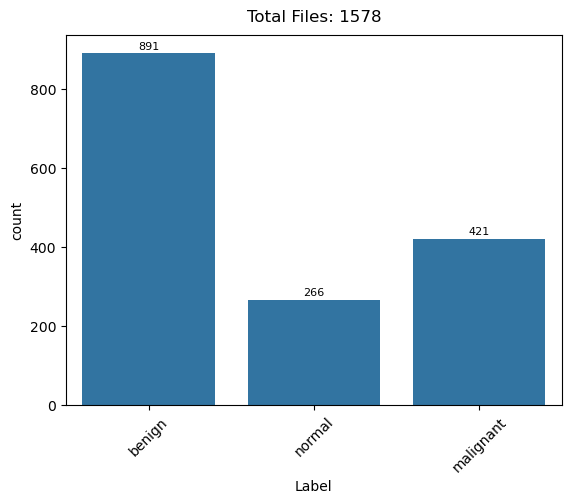

In [5]:
# Create a countplot() using Seaborn, where x-axis represents the "Label" column of the training_data DataFrame
ax = sns.countplot(x=training_data["Label"])

# Display count inside each bar as integers
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=8)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Add a title with the total count of files
plt.title(f'Total Files: {len(training_data)}', pad=10)

# Show the plot
plt.show()

### IV. Collect Data Paths & Labels from Directory Structure

In [6]:
data_paths = []
labels = []

main_dirs = os.listdir(train_data)
for folder_name in main_dirs:
    folder_path = os.path.join(train_data, folder_name)
    files = os.listdir(folder_path)
    for file in files:
        file_path = os.path.join(folder_path, file)
        data_paths.append(file_path)
        labels.append(folder_name)

### V. Data Preprocessing

In [7]:
# Set the batch size for training
batch_size = 16

# Define the target image size for preprocessing
image_size = (256, 256)

# Specify the number of color channels in the images (3 for RGB)
num_channels = 3

# Create the image shape tuple based on the specified size and channels
image_shape = (image_size[0], image_size[1], num_channels)

# Create a Pandas Series containing file paths with the name 'Path'
data_dirs = pd.Series(data_paths, name='Path')

# Create a Pandas Series containing corresponding labels with the name 'Label'
classes = pd.Series(labels, name='Label')

def preprocess_image(img):
    return img

# Split the data into training and validation-test sets
train_df, val_test_df = train_test_split(
    training_data, 
    train_size=0.8, 
    shuffle=True, 
    random_state=123
)

# Further split the validation-test set into validation and test sets
val_df, test_df = train_test_split(
    val_test_df, 
    train_size=0.5, 
    shuffle=True, 
    random_state=123
)

# ImageDataGenerator configuration
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image, 
    rescale=1.0/255
)

# Convert the 'Label' column to string type
train_df['Label'] = train_df['Label'].astype(str)
val_df['Label'] = val_df['Label'].astype(str)

# Create generators for training, validation, and testing
train_generator = datagen.flow_from_dataframe(
    train_df, 
    x_col='Path', 
    y_col='Label',
    target_size=image_size, 
    class_mode='categorical',
    color_mode='rgb', 
    shuffle=True, 
    batch_size=batch_size
)

valid_generator = datagen.flow_from_dataframe(
    val_df, 
    x_col='Path', 
    y_col='Label',
    target_size=image_size, 
    class_mode='categorical',
    color_mode='rgb', 
    shuffle=True, 
    batch_size=batch_size
)

Found 1262 validated image filenames belonging to 3 classes.
Found 158 validated image filenames belonging to 3 classes.


**Display Class Names**

In [8]:
# Get the class indices (mapping of the class names to numerical indices) from the training generator
class_indices = train_generator.class_indices

# Display the keys (class names) from the class_indices dictionary
class_indices.keys()

dict_keys(['benign', 'malignant', 'normal'])

In [9]:
# Initialize an empty list to store class labels
labels = []

# Iterate through the keys (class names) in the class_indices dictionary
for key in class_indices.keys():
    labels.append(key)  # Append each class name to the labels list

# Calculate the total no. of unique labels
total_labels = len(labels)

# Print the list of class labels and the total no. of unique labels
print("Labels: ", labels)
print("\nTotal no. of unique labels:", total_labels)

Labels:  ['benign', 'malignant', 'normal']

Total no. of unique labels: 3


**Visualize a Subset of Images from the Training Set**

(345, 378)
(470, 562, 3)
(571, 759, 3)
(598, 763, 3)
(611, 729)
(469, 566)
(695, 928, 3)
(458, 569)


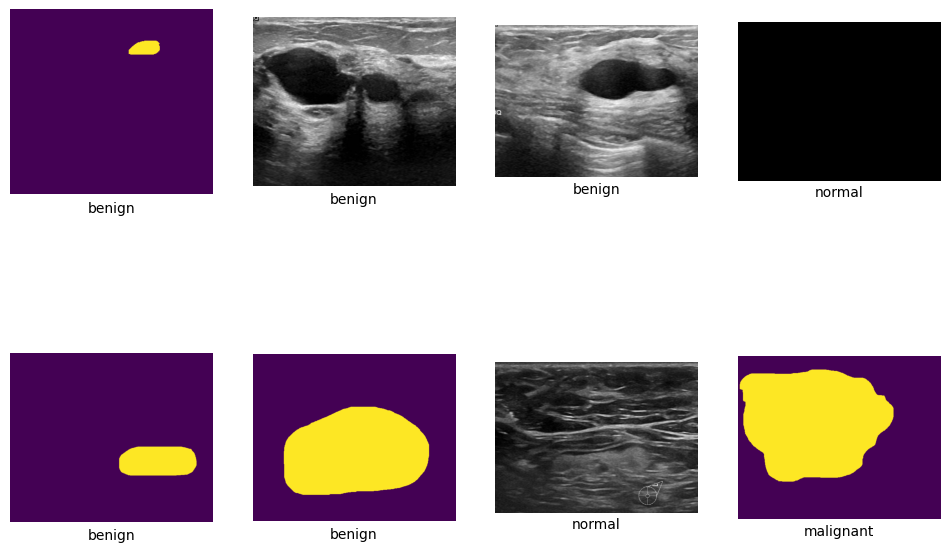

In [10]:
# Set the number of rows and columns for the subplot grid
no_of_rows = 2
no_of_columns = 4

# Create a subplot grid with the specified number of rows and columns
fig, axes = plt.subplots(no_of_rows, no_of_columns, figsize=(12, 8))

# Iterate through the rows
for i in range(no_of_rows):
    # Iterate through the columns
    for j in range(no_of_columns):
        # Calculate the index for accessing the data
        index = i * no_of_columns + j

        # Check if the index is within the bounds of the data
        if index < len(training_data):

            # Open the image using the PIL library
            im = Image.open(training_data.iloc[index]['Path'])

            # Convert the PIL image to a NumPy array
            img = np.array(im)

            # Print the shape of the image array
            print(img.shape)

            # Display the image on the subplot at position (i, j)
            axes[i, j].imshow(img)

            # Turn off axis labels for better visualization
            axes[i, j].axis('off')

            # Get the label for the current image and display it as text
            label = training_data.iloc[index]['Label']
            axes[i, j].text(0.5, -0.1, label, ha='center', transform=axes[i, j].transAxes)

# Show the entire subplot grid
plt.show()

### VI. Build Model

In [11]:
# Load DenseNet-121 with pre-trained weights
base_model = DenseNet121(
    weights='imagenet',
    include_top=False, 
    input_shape=(256, 256, 3)
)

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Create model
model = Sequential()

# Add the pre-trained DenseNet-121 base model
model.add(base_model)

# Flatten the output of the base model
model.add(Flatten())

# Add fully connected layers with dropout for regularization
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))

# Additional layers for classification
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))

# Display the summary of the model architecture
model.summary()

2025-08-25 10:23:25.657210: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-08-25 10:23:25.657226: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:160] env: CUDA_VISIBLE_DEVICES="-1"
2025-08-25 10:23:25.657229: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] CUDA_VISIBLE_DEVICES is set to -1 - this hides all GPUs from CUDA
2025-08-25 10:23:25.657231: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:171] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-08-25 10:23:25.657234: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:176] retrieving CUDA diagnostic information for host: sdu-133749
2025-08-25 10:23:25.657235: I external/local_xla/xla/stream_executor/cuda/cu

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 8, 8, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    67,109,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,787,843 (289.11 MB)

 Trainable params: 68,750,339 (262.26 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

**Visualize the Neural Network Architecture**

In [12]:
# Specify the file path for saving the visualization image
#model_visualization_path = "/kaggle/working/nn_architecture.png"

# Plot the model and save the visualization image
#plot_model(model, to_file=model_visualization_path, show_shapes=True, show_layer_names=True)

# Display the visualization image
#IPImage(filename=model_visualization_path)

**Create Model Checkpoint Callback to Save Best Model**

In [13]:
# Define the path to save the best model checkpoint
checkpoint_path = "model.h5"

# Create a ModelCheckpoint callback
# This callback saves the model when validation accuracy improves
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  # Monitor validation accuracy
    save_best_only=True,     # Save only the best model
    mode='max',              # Save based on the maximum validation accuracy
    verbose=1                # Display progress information
)                

### VII. Compile Model

In [14]:
# Compile the model with the Adam optimizer, categorical crossentropy loss, and accuracy metric
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # Categorical crossentropy loss for multi-class classification
    metrics=['accuracy']              # Monitor accuracy during training
)              

In [15]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices("GPU"))



TensorFlow version: 2.20.0
GPU available: []


### VIII. Train Model

In [16]:
# Train the model using the fit() method
history = model.fit(
    train_generator,                                   # Training data generator
    steps_per_epoch=train_generator.samples // train_generator.batch_size,  # Number of steps per epoch
    epochs=10,                                         # Number of training epochs
    validation_data=valid_generator,                   # Validation data generator
    validation_steps=valid_generator.samples // valid_generator.batch_size,  # Number of validation steps
    callbacks=[checkpoint]                             # List of callbacks, including the ModelCheckpoint
)

Epoch 1/10


/home/naeem/miniconda3/envs/biogpt/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.5414 - loss: 4.9964
Epoch 1: val_accuracy improved from None to 0.74306, saving model to model.h5


78/78 ━━━━━━━━━━━━━━━━━━━━ 48s 557ms/step - accuracy: 0.6140 - loss: 2.5982 - val_accuracy: 0.7431 - val_loss: 0.6182
Epoch 2/10
 1/78 ━━━━━━━━━━━━━━━━━━━━ 38s 496ms/step - accuracy: 0.6875 - loss: 0.4807

/home/naeem/miniconda3/envs/biogpt/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.74306
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.6875 - loss: 0.4807 - val_accuracy: 0.5694 - val_loss: 0.6695
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.7451 - loss: 0.5874
Epoch 3: val_accuracy improved from 0.74306 to 0.83333, saving model to model.h5


78/78 ━━━━━━━━━━━━━━━━━━━━ 40s 517ms/step - accuracy: 0.7640 - loss: 0.5443 - val_accuracy: 0.8333 - val_loss: 0.4101
Epoch 4/10
 1/78 ━━━━━━━━━━━━━━━━━━━━ 36s 477ms/step - accuracy: 0.6250 - loss: 0.5526
Epoch 4: val_accuracy did not improve from 0.83333
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.6250 - loss: 0.5526 - val_accuracy: 0.8264 - val_loss: 0.4192
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.8042 - loss: 0.4378
Epoch 5: val_accuracy improved from 0.83333 to 0.90278, saving model to model.h5


78/78 ━━━━━━━━━━━━━━━━━━━━ 40s 509ms/step - accuracy: 0.8138 - loss: 0.4116 - val_accuracy: 0.9028 - val_loss: 0.3495
Epoch 6/10
 1/78 ━━━━━━━━━━━━━━━━━━━━ 37s 488ms/step - accuracy: 0.9375 - loss: 0.3032
Epoch 6: val_accuracy did not improve from 0.90278
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9375 - loss: 0.3032 - val_accuracy: 0.8889 - val_loss: 0.3451
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.8694 - loss: 0.3131
Epoch 7: val_accuracy did not improve from 0.90278
78/78 ━━━━━━━━━━━━━━━━━━━━ 39s 500ms/step - accuracy: 0.8604 - loss: 0.3377 - val_accuracy: 0.8611 - val_loss: 0.3322
Epoch 8/10
 1/78 ━━━━━━━━━━━━━━━━━━━━ 34s 452ms/step - accuracy: 0.8750 - loss: 0.2883
Epoch 8: val_accuracy did not improve from 0.90278
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.8750 - loss: 0.2883 - val_accuracy: 0.8542 - val_loss: 0.3474
Epoch 9/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.8803 - loss: 0.3009
Epoch 9: val_accuracy did not imp

**Display Training History**

In [ ]:
def train_image_model():
    # Train the model using the fit() method
    history = model.fit(
        train_generator,                                   # Training data generator
        steps_per_epoch=train_generator.samples // train_generator.batch_size,  # Number of steps per epoch
        epochs=10,                                         # Number of training epochs
        validation_data=valid_generator,                   # Validation data generator
        validation_steps=valid_generator.samples // valid_generator.batch_size,  # Number of validation steps
        callbacks=[checkpoint]                             # List of callbacks, including the ModelCheckpoint
    )
    return history

if training_mode == 'image':
    history = train_image_model()

In [17]:
# Create a Pandas DataFrame containing the training history (metrics) of the model
train_history = pd.DataFrame(history.history)

# Add a new column 'Epoch' with values from 1 to the number of epochs
train_history['Epoch'] = range(1, len(train_history) + 1)

# Reorder columns for clarity
train_history = train_history[['Epoch', 'loss', 'accuracy', 'val_loss', 'val_accuracy']]

# Display the DataFrame
train_history

,Epoch,loss,accuracy,val_loss,val_accuracy
0,1,2.598222,0.613965,0.618205,0.743056
1,2,0.480662,0.687500,0.669464,0.569444
2,3,0.544336,0.764045,0.410136,0.833333
3,4,0.552609,0.625000,0.419171,0.826389
4,5,0.411550,0.813804,0.349547,0.902778
5,6,0.303237,0.937500,0.345060,0.888889
6,7,0.337693,0.860353,0.332226,0.861111
7,8,0.288284,0.875000,0.347360,0.854167
8,9,0.292615,0.878812,0.261151,0.888889
9,10,0.219943,0.937500,0.282078,0.895833


### IX. Evaluate Model (Train & Validation Set)

In [18]:
# Evaluate the model on the train set
train_loss, train_accuracy = model.evaluate(train_generator, steps=train_generator.samples // train_generator.batch_size)

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(valid_generator, steps=valid_generator.samples // valid_generator.batch_size)

# Convert accuracy to percentage
train_accuracy_percentage = train_accuracy * 100
val_accuracy_percentage = val_accuracy * 100

# Create a Pandas DataFrame to display the results
evaluation_results = pd.DataFrame({
    'Set': ['Train', 'Validation'],
    'Loss': [train_loss, val_loss],
    'Accuracy': [f'{train_accuracy_percentage:.2f}%', f'{val_accuracy_percentage:.2f}%']
})

# Display the evaluation results DataFrame
evaluation_results

78/78 ━━━━━━━━━━━━━━━━━━━━ 21s 269ms/step - accuracy: 0.9447 - loss: 0.1783
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 294ms/step - accuracy: 0.8889 - loss: 0.2900


,Set,Loss,Accuracy
0,Train,0.178307,94.47%
1,Validation,0.289953,88.89%


**Plot Loss & Accuracy**

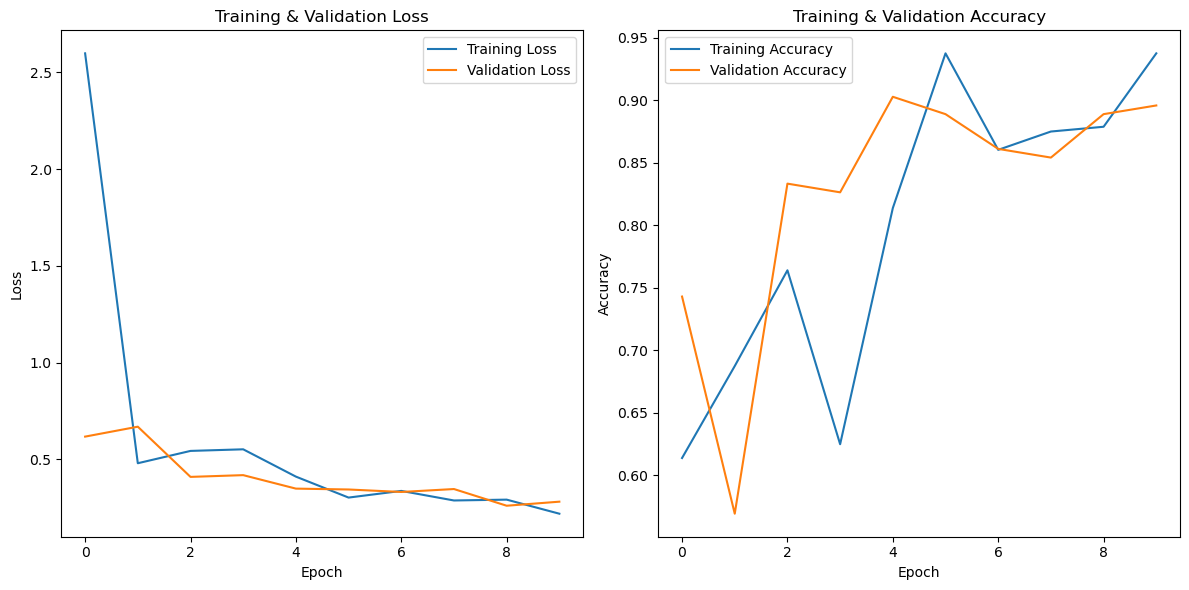

In [19]:
# Plotting the training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_history['loss'], label='Training Loss')
plt.plot(train_history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_history['accuracy'], label='Training Accuracy')
plt.plot(train_history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

## Textual Training

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [21]:
dataset = load_breast_cancer()
X = dataset.data
Y = dataset.target

In [22]:
# Create a DataFrame using the features and target
df = pandas.DataFrame(dataset.data, columns=dataset.feature_names)

# Add the target (malignant/benign) as a column in the DataFrame
df['target'] = dataset.target

In [26]:
#Split into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


In [27]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train) #both fit and transform
X_test = scaler.transform(X_test) #only transform

In [28]:
#transform numpy array into PyTorch tensors

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.float32)

In [29]:
 # Define hyperparameters

input_size = X_train.shape[1]
hidden_size = 64
output_size = 1
learning_rate = 0.01 # One can play with this values.
num_epochs = 100 # One can play with this values.

In [30]:
#Define loss and the optimiser

criterion = nn.BCELoss() #BCELoss = Binary Cross Entropy Loss, which is commonly used in binary classification problems, where the task is to classify inputs into one of two classes. It's a measure of how well the model's predicted probabilities match the true binary labels
optimiser = optim.Adam(model.parameters(), lr = learning_rate) 

AttributeError: 'Sequential' object has no attribute 'parameters'

In [ ]:
# Training the model

# Epoch is when your entire model has gone through the process of forward and backward propagation
for epoch in range(num_epochs):
    model.train()
    optimiser.zero_grad() # Each time the batch is passed, it resets the gradients to 0.
    outputs = model(X_train)
    loss = criterion(outputs, Y_train.view(-1,1))
    loss.backward()
    optimiser.step() # Updation of weights and biases.

    # Calculate accuracy
    with torch.no_grad():
        predicted = outputs.round()
        correct = (predicted == Y_train.view(-1,1)).float().sum()
        accuracy = correct/Y_train.size(0)

    #For every tenth iteration, we se the loss and accuracy of the training
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss : {loss.item():.4f}, Accuracy: {accuracy.item() * 100:.2f}%")

In [ ]:
# Evaluation of training set
model.eval()

with torch.no_grad():

    outputs = model(X_train)
    predicted = outputs.round()
    correct = (predicted == Y_train.view(-1,1)).float().sum()
    accuracy = correct/Y_train.size(0)
    print(f"Accuracy on training data: {accuracy.item() * 100:.2f}%")

In [ ]:
# Evaluation of test set
model.eval()

with torch.no_grad():

    outputs = model(X_test)
    predicted = outputs.round()
    correct = (predicted == Y_test.view(-1,1)).float().sum()
    accuracy = correct/Y_test.size(0)
    print(f"Accuracy on test data: {accuracy.item() * 100:.2f}%")

In [ ]:
# Print confusion matrix and relevant test metrics as a plot
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

model.eval()
with torch.no_grad():
    outputs = model(X_test)
    predicted = outputs.round().view(-1).cpu().numpy()
    y_true = Y_test.cpu().numpy()

    # Confusion matrix
    cm = confusion_matrix(y_true, predicted)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign','Malignant'], yticklabels=['Benign','Malignant'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification report (precision, recall, f1-score)
    print('\nClassification Report:')
    print(classification_report(y_true, predicted, digits=4))